## Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import os
from PIL import Image

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import torchvision.transforms as transforms

## Loading test dataset

In [2]:
X_test = torch.load("../test/X_test.pt")
y_test = torch.load("../test/y_test.pt")

In [3]:
X_test.shape, y_test.shape

(torch.Size([2281, 3, 32, 32]), torch.Size([2281]))

## Creating DataLoader

In [4]:
test_dataset = TensorDataset(X_test, y_test)

In [5]:
batch_size=32
test_shuffle=False

In [6]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=test_shuffle)

## Loading models

In [7]:
def calculate_h_out_w_out(h_in, w_in, kernel_size, out_channels, stride=(1, 1), padding=(0, 0), dilation=(1, 1)):
    h_out = (h_in + 2 * padding[0] - dilation[0] * (kernel_size[0] - 1) - 1) // stride[0] + 1
    w_out = (w_in + 2 * padding[1] - dilation[1] * (kernel_size[1] - 1) - 1) // stride[1] + 1
    assert isinstance(h_out, int), "Output height is not an integer"
    assert isinstance(w_out, int), "Output width is not an integer"
    return (h_out, w_out, out_channels)

### Model 1 Loading

In [8]:
class CNN(nn.Module):
    def __init__(self, in_height, in_width, in_channels, num_classes):
        super(CNN, self).__init__()
        self.in_features = (in_height, in_width, in_channels)
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=(5, 5), padding=(2, 2))
        self.in_features = calculate_h_out_w_out(in_height, in_width, (5, 5), 16, padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.in_features = calculate_h_out_w_out(self.in_features[0], self.in_features[1], (2, 2), self.in_features[2], stride=(2, 2))
        self.fc1 = nn.Linear(in_features=self.in_features[0] * self.in_features[1] * self.in_features[2], out_features=2048)
        self.relu2 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=2048, out_features=num_classes)
        self.logSoftmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu2(x)
        x = self.fc2(x)
        x = self.logSoftmax(x)
        return x

In [9]:
image_height = X_test.shape[2]
image_width = X_test.shape[2]
n_channels = X_test.shape[1]
n_classes = len(np.unique(y_test))

In [10]:
model1 = CNN(in_height=image_height, in_width=image_width, in_channels=n_channels, num_classes=n_classes)
model1.load_state_dict(torch.load('models/model1.pth'))
model1.eval()

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=2048, bias=True)
  (relu2): ReLU()
  (fc2): Linear(in_features=2048, out_features=27, bias=True)
  (logSoftmax): LogSoftmax(dim=1)
)

### Model 2 Loading

In [11]:
class CNN(nn.Module):
    def __init__(self, in_height, in_width, in_channels, num_classes):
        super(CNN, self).__init__()
        self.in_features = (in_height, in_width, in_channels)
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=(5, 5), padding=(2, 2))
        self.in_features = calculate_h_out_w_out(in_height, in_width, (5, 5), 16, padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.in_features = calculate_h_out_w_out(self.in_features[0], self.in_features[1], (2, 2), self.in_features[2], stride=(2, 2))
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5, 5))
        self.in_features = calculate_h_out_w_out(self.in_features[0], self.in_features[1], (5, 5), 32)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.in_features = calculate_h_out_w_out(self.in_features[0], self.in_features[1], (2, 2), self.in_features[2], stride=(2, 2))
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=(1, 1))
        self.in_features = calculate_h_out_w_out(self.in_features[0], self.in_features[1], (3, 3), 64, padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.in_features = calculate_h_out_w_out(self.in_features[0], self.in_features[1], (2, 2), self.in_features[2], stride=(2, 2)) 
        self.fc1 = nn.Linear(in_features=self.in_features[0] * self.in_features[1] * self.in_features[2], out_features=2048)
        self.relu_fc1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(in_features=2048, out_features=1024)
        self.relu_fc2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(in_features=1024, out_features=num_classes)
        self.logSoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.conv1(x) 
        x = self.relu1(x) 
        x = self.maxpool1(x) 
        x = self.conv2(x) 
        x = self.relu2(x)  
        x = self.maxpool2(x) 
        x = self.conv3(x)  
        x = self.relu3(x) 
        x = self.maxpool3(x) 
        x = x.view(x.size(0), -1) 
        x = self.fc1(x) 
        x = self.relu_fc1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu_fc2(x) 
        x = self.dropout2(x) 
        x = self.fc3(x)  
        x = self.logSoftmax(x)
        return x  

In [12]:
model2 = CNN(in_height=image_height, in_width=image_width, in_channels=n_channels, num_classes=n_classes)
model2.load_state_dict(torch.load('models/model2.pth'))
model2.eval()

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (maxpool3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=576, out_features=2048, bias=True)
  (relu_fc1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=2048, out_features=1024, bias=True)
  (relu_fc2): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=1024, out_features=27, bias=True)
  (logSoftmax): LogSoftmax(dim=1)
)

## Evaluate models

In [13]:
def evaluate(model, criterion, loader, multiclass=False):
    model.eval()
    
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    
    predicted_labels, true_labels = [], []
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            
            total_loss += criterion(outputs.squeeze(), labels).item()

            if multiclass:
                predicted = torch.argmax(outputs, dim=1)
            else:
                predicted = (outputs > 0.5).float()
                
            predicted_labels.extend(predicted.squeeze().tolist())
            true_labels.extend(labels.tolist())

            total_samples += labels.size(0)
            total_correct += (predicted.squeeze() == labels).sum().item()

    accuracy = accuracy_score(true_labels, predicted_labels)
    precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')

    avg_loss = total_loss / len(loader)
    accuracy = total_correct / total_samples

    return avg_loss, accuracy, precision, recall, f1_score

In [14]:
criterion = nn.CrossEntropyLoss()

avg_loss1, accuracy1, precision1, recall1, f1_score1 = evaluate(model1, criterion, test_loader, multiclass=True)
avg_loss2, accuracy2, precision2, recall2, f1_score2 = evaluate(model2, criterion, test_loader, multiclass=True)

## Plot comparison

In [15]:
def plot_comparison(metrics1, metrics2, metric_names):
    avg_loss1, accuracy1, precision1, recall1, f1_score1 = metrics1
    avg_loss2, accuracy2, precision2, recall2, f1_score2 = metrics2

    metrics_labels = metric_names
    model1_metrics = [avg_loss1, accuracy1, precision1, recall1, f1_score1]
    model2_metrics = [avg_loss2, accuracy2, precision2, recall2, f1_score2]

    x = np.arange(len(metrics_labels))

    plt.figure(figsize=(16, 10))
    
    plt.subplot(2, 1, 1)
    bar_width = 0.35
    opacity = 0.8
    
    rects1 = plt.bar(x - bar_width/2, model1_metrics, bar_width, alpha=opacity, color='skyblue', label='Model 1')
    rects2 = plt.bar(x + bar_width/2, model2_metrics, bar_width, alpha=opacity, color='salmon', label='Model 2')
    
    plt.xlabel('Metrics')
    plt.ylabel('Values')
    plt.title('Model Comparison: Metrics')
    plt.xticks(x, metrics_labels, rotation=45, ha='right')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    for rect in rects1 + rects2:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2.0, height, f'{height:.2f}', ha='center', va='bottom', fontsize=10)
    
    plt.subplot(2, 1, 2)
    plt.plot(x, model1_metrics, marker='o', linestyle='-', color='skyblue', label='Model 1', linewidth=2, markersize=8)
    plt.plot(x, model2_metrics, marker='s', linestyle='--', color='salmon', label='Model 2', linewidth=2, markersize=8)
    
    plt.xlabel('Metrics')
    plt.ylabel('Values')
    plt.title('Model Comparison: Metrics (Line Plot)')
    plt.xticks(x, metrics_labels, rotation=45, ha='right')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

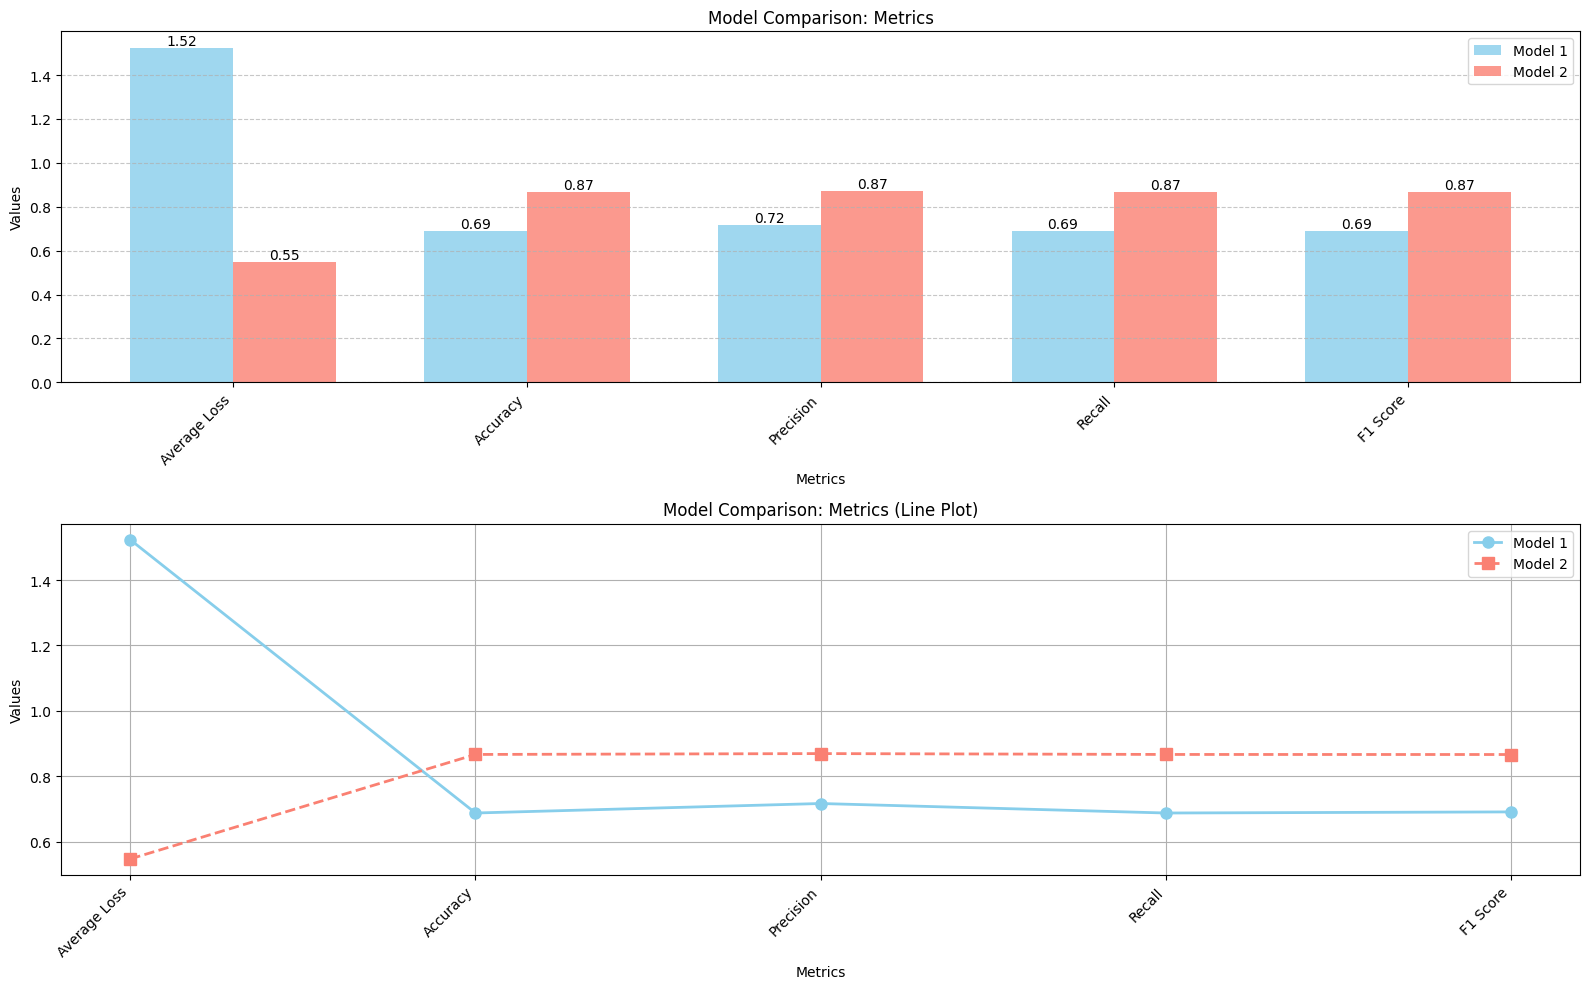

In [16]:
plot_comparison(
    (avg_loss1, accuracy1, precision1, recall1, f1_score1),
    (avg_loss2, accuracy2, precision2, recall2, f1_score2),
    ['Average Loss', 'Accuracy', 'Precision', 'Recall', 'F1 Score']
)